In [1]:
%matplotlib inline

## Hyperparameters

In [2]:
MAX_SENTENCE_LENGTH = 180
training_epochs = 50
batch_size = 256
nb_classes = 2

dataset_name = 'imdb'
model_name = 'unsupervised'
args = {}
args['is_hierarchical'] = False
args['max_sentence_length'] = MAX_SENTENCE_LENGTH
args['embedding_type'] = 'word2vec'
args['lambda_word'] = 3.0
args['embedding_dim'] = 300
args['attention_dim'] = 300
args['rnn_dim'] = 150
args['mu_classification'] = 1.0
args['mu_supervision'] = 1.0
args['include_dense_batch_normalization'] = False
args['include_dense_dropout'] = True
args['nb_dense'] = 1
args['dense_dim'] = 300
args['dense_dropout'] = 0.5
# args['decay'] = 2.0
# args['TVD_threshold'] = 0.3

## Dataset Preparation

In [3]:
# refer: http://ai.stanford.edu/~amaas/data/sentiment/

import os

data_dir = "./datasets/aclImdb"
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

def load_dataset(split='train'):
    x_data = []
    y_data = []
    
    base_dir = './datasets/aclImdb'
    split_dir = os.path.join(base_dir, split)
    for sentiment, y in [('neg', 0), ('pos', 1)]:
        data_dir = os.path.join(split_dir, sentiment)
        for file_name in os.listdir(data_dir):
            file_path = os.path.join(data_dir, file_name)
            with open(file_path, 'r', encoding='utf-8') as fp:
                review = fp.read()
            x_data.append(review)
            y_data.append(y)
            
    return x_data, y_data
            
train_x_data, train_y_data = load_dataset(split='train')
test_x_data, test_y_data = load_dataset(split='test')

print("len(train_x_data): {}".format(len(train_x_data)))
print("len(test_x_data): {}".format(len(test_x_data)))

len(train_x_data): 25000
len(test_x_data): 25000


In [32]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from nltk.tokenize import sent_tokenize

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x_data)
tokenizer.fit_on_texts(test_x_data)

max_nb_words = len(tokenizer.word_index) + 1

def doc2sequential(text,
                   max_sentence_length=MAX_SENTENCE_LENGTH):
    tokenized_sentences = tokenizer.texts_to_sequences([text])
    tokenized_sentences = pad_sequences(tokenized_sentences, maxlen=max_sentence_length)
    
    return tokenized_sentences[0]
            
def build_sequential_dataset(x_data, y_data,
                                               max_sentence_length=MAX_SENTENCE_LENGTH,
                                               tokenizer=tokenizer):
    nb_instances = len(x_data)
    X_data = np.zeros((nb_instances, max_sentence_length), dtype='int32')
    for i, review in enumerate(x_data):
        tokenized_sentence = doc2sequential(review)
        X_data[i] = tokenized_sentence[None, ...]
        
    nb_classes = len(set(y_data))
    Y_data = to_categorical(y_data, nb_classes)
    
    return X_data, Y_data

if args['is_hierarchical'] == True:
    train_X_data, train_Y_data = build_hierarchical_dataset(train_x_data, train_y_data)
    test_X_data, test_Y_data = build_hierarchical_dataset(test_x_data, test_y_data)
else:
    train_X_data, train_Y_data = build_sequential_dataset(train_x_data, train_y_data)
    test_X_data, test_Y_data = build_sequential_dataset(test_x_data, test_y_data)

print("train_X_data.shape: {}".format(train_X_data.shape))
print("test_X_data.shape: {}".format(test_X_data.shape))

train_X_data.shape: (25000, 180)
test_X_data.shape: (25000, 180)


In [5]:
from sklearn.model_selection import train_test_split
train_X_data, val_X_data, train_Y_data, val_Y_data = train_test_split(train_X_data, train_Y_data, 
                                                                      test_size=0.1, 
                                                                      random_state=42)

print("train_X_data.shape: {}".format(train_X_data.shape))
print("train_Y_data.shape: {}".format(train_Y_data.shape))
print("val_X_data.shape: {}".format(val_X_data.shape))
print("val_Y_data.shape: {}".format(val_Y_data.shape))

train_X_data.shape: (22500, 180)
train_Y_data.shape: (22500, 2)
val_X_data.shape: (2500, 180)
val_Y_data.shape: (2500, 2)


In [6]:
embedding_dir = './embeddings/'

def load_word2vec(tokenizer=tokenizer):
    from gensim.models import KeyedVectors
    embedding_path = os.path.join(embedding_dir, 'GoogleNews-vectors-negative300.bin')
    embeddings_index = KeyedVectors.load_word2vec_format(embedding_path, binary=True)
    
    return embeddings_index
    
def load_embedding(embedding_type='word2vec',
                   tokenizer=tokenizer,
                   embedding_dim=300):
    
    if embedding_type == 'word2vec':
        embeddings_index = load_word2vec()
        
    embedding_matrix = np.random.normal(0, 1, (max_nb_words, embedding_dim))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = embeddings_index[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

embedding_matrix = load_embedding('word2vec')

print("embedding_matrix.shape: {}".format(embedding_matrix.shape))

embedding_matrix.shape: (124253, 300)


## Training Teacher(BiGRU+Attention) Model

In [7]:
from tensorflow import keras
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Embedding, Dense, Layer
from tensorflow.keras.layers import Lambda, Permute, RepeatVector, Multiply
from tensorflow.keras.layers import Bidirectional, TimeDistributed
from tensorflow.keras.layers import CuDNNGRU
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

class AttentionLayer(Layer):
    def __init__(self, attention_dim, **kwargs):
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='Attention_Weight',
                                 shape=(input_shape[-1].value, self.attention_dim),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='Attention_Bias',
                                 shape=(self.attention_dim, ),
                                 initializer='random_normal',
                                 trainable=True)
        self.u = self.add_weight(name='Attention_Context_Vector',
                                 shape=(self.attention_dim, 1),
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        # refer to the original paper
        # link: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
        u_it = K.tanh(K.dot(x, self.W) + self.b)
        a_it = K.dot(u_it, self.u)
        a_it = K.squeeze(a_it, -1)
        a_it = K.softmax(a_it)
        
        return a_it
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])
    

def WeightedSum(attentions, representations):
    # from Shape(batch_size, len_units) to Shape(batch_size, rnn_dim * 2, len_units)
    repeated_attentions = RepeatVector(K.int_shape(representations)[-1])(attentions)
    # from Shape(batch_size, rnn_dim * 2, len_units) to Shape(batch_size, len_units, lstm_dim * 2)
    repeated_attentions = Permute([2, 1])(repeated_attentions)

    # compute representation as the weighted sum of representations
    aggregated_representation = Multiply()([representations, repeated_attentions])
    aggregated_representation = Lambda(lambda x: K.sum(x, axis=1))(aggregated_representation)

    return aggregated_representation


def SeqAtt(embedding_matrix,
           max_sentence_length,
           nb_classes,
           embedding_dim=300,
           attention_dim=100,
           rnn_dim=150,
           include_dense_batch_normalization=False,
           include_dense_dropout=True,
           nb_dense=1,
           dense_dim=300,
           dense_dropout=0.2,
           optimizer = keras.optimizers.Adam(lr=0.001)):
    
    # embedding_matrix = (max_nb_words + 1, embedding_dim)
    max_nb_words = embedding_matrix.shape[0] - 1
    embedding_layer = Embedding(max_nb_words + 1, 
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_sentence_length,
                                trainable=False)

    # first, build a sentence encoder
    sequence_input = Input(shape=(max_sentence_length, ), dtype='int32')
    embedded_sequence = embedding_layer(sequence_input)
    embedded_sequence = Dropout(dense_dropout)(embedded_sequence)
    contextualized_sequence = Bidirectional(CuDNNGRU(rnn_dim, return_sequences=True))(embedded_sequence)
    
    # word attention computation
    word_attention = AttentionLayer(attention_dim)(contextualized_sequence)
    print(word_attention)
    # Tensor("attention_layer_2/Softmax:0", shape=(?, 180), dtype=float32)
        
    sequence_representation = WeightedSum(word_attention, contextualized_sequence)
        
    # finally, add fc layers for classification
    fc_layers = Sequential()
    for _ in range(nb_dense):
        if include_dense_batch_normalization == True:
            fc_layers.add(BatchNormalization())
        fc_layers.add(Dense(dense_dim, activation='relu'))
        if include_dense_dropout == True:
            fc_layers.add(Dropout(dense_dropout))
    fc_layers.add(Dense(nb_classes, activation='softmax'))
    
    pred_sentiment = fc_layers(sequence_representation)

    model = Model(inputs=[sequence_input],
                  outputs=[pred_sentiment])
    
    ############### build attention extractor ###############
    attention_extractor = Model(inputs=[sequence_input],
                                     outputs=[word_attention])
    sequence_encoder = Model(inputs=[sequence_input],
                             outputs=[contextualized_sequence])
    classifier_module = fc_layers
    
    model.compile(loss=['categorical_crossentropy'],
              optimizer=optimizer,
              metrics=['accuracy'])

    return model, attention_extractor, sequence_encoder, classifier_module

teacher_path = './models/checkpoints/{}-teacher.h5'.format(dataset_name)
checkpointer = ModelCheckpoint(filepath=teacher_path,
                               monitor='val_acc',
                               verbose=False,
                               save_best_only=True,
                               mode='max')

teacher, attention_extractor, sequence_encoder, classifier_module = SeqAtt(embedding_matrix=embedding_matrix,
                                                    max_sentence_length=MAX_SENTENCE_LENGTH,
                                                    nb_classes=nb_classes,
                                                    embedding_dim=args['embedding_dim'],
                                                    attention_dim=args['attention_dim'],
                                                    rnn_dim=args['rnn_dim'],
                                                    include_dense_batch_normalization=args['include_dense_batch_normalization'],
                                                    include_dense_dropout=args['include_dense_dropout'],
                                                    nb_dense=args['nb_dense'],
                                                    dense_dim=args['dense_dim'],
                                                    dense_dropout=args['dense_dropout'],
                                                    optimizer = keras.optimizers.Adam(lr=0.001))

history = teacher.fit(x=[train_X_data],
                    y=[train_Y_data],
                    batch_size=batch_size,
                    epochs=training_epochs,
                    verbose=True,
                    validation_data=(val_X_data, val_Y_data),
                    callbacks=[checkpointer])

Tensor("attention_layer/Softmax:0", shape=(?, 180), dtype=float32)
Train on 22500 samples, validate on 2500 samples
Epoch 1/50
22500/22500 [==============================] - 6s 285us/step - loss: 0.6657 - acc: 0.5843 - val_loss: 0.5588 - val_acc: 0.7268
Epoch 2/50
22500/22500 [==============================] - 5s 224us/step - loss: 0.5673 - acc: 0.7207 - val_loss: 0.5036 - val_acc: 0.7700
Epoch 3/50
22500/22500 [==============================] - 5s 224us/step - loss: 0.5380 - acc: 0.7425 - val_loss: 0.5005 - val_acc: 0.7728
Epoch 4/50
22500/22500 [==============================] - 5s 224us/step - loss: 0.5138 - acc: 0.7587 - val_loss: 0.4700 - val_acc: 0.7860
Epoch 5/50
22500/22500 [==============================] - 5s 224us/step - loss: 0.4911 - acc: 0.7752 - val_loss: 0.4337 - val_acc: 0.8036
Epoch 6/50
22500/22500 [==============================] - 5s 225us/step - loss: 0.4941 - acc: 0.7740 - val_loss: 0.4474 - val_acc: 0.7996
Epoch 7/50
22500/22500 [==============================] 

In [8]:
teacher.load_weights(teacher_path)
teacher_score = teacher.evaluate(test_X_data, test_Y_data, verbose=0, batch_size=batch_size)
print("Test Accuracy of teacher: {}".format(teacher_score[1]))

Test Accuracy of teacher: 0.8795199999046326


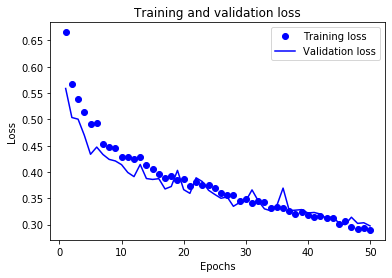

In [9]:
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

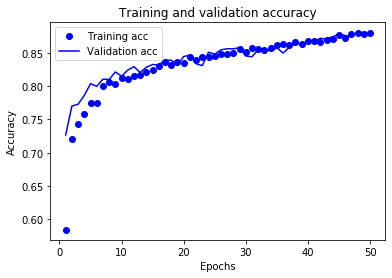

In [10]:
plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Vanilla Knowledge Distillation

In [11]:
train_soft = teacher.predict(x=[train_X_data],
                           batch_size=batch_size,
                           verbose=True)
val_soft = teacher.predict(x=[val_X_data],
                         batch_size=batch_size,
                         verbose=True)
test_soft = teacher.predict(x=[test_X_data],
                          batch_size=batch_size,
                          verbose=True)
print(train_soft.shape)
print(val_soft.shape)
print(test_soft.shape)

25000/25000 [==============================] - 2s 68us/step
(22500, 2)
(2500, 2)
(25000, 2)


In [12]:
from tensorflow import keras
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Embedding, Dense, Layer
from tensorflow.keras.layers import Lambda, Permute, RepeatVector, Multiply
from tensorflow.keras.layers import Bidirectional, TimeDistributed
from tensorflow.keras.layers import CuDNNGRU
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

class AttentionLayer(Layer):
    def __init__(self, attention_dim, **kwargs):
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='Attention_Weight',
                                 shape=(input_shape[-1].value, self.attention_dim),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='Attention_Bias',
                                 shape=(self.attention_dim, ),
                                 initializer='random_normal',
                                 trainable=True)
        self.u = self.add_weight(name='Attention_Context_Vector',
                                 shape=(self.attention_dim, 1),
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        # refer to the original paper
        # link: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
        u_it = K.tanh(K.dot(x, self.W) + self.b)
        a_it = K.dot(u_it, self.u)
        a_it = K.squeeze(a_it, -1)
        a_it = K.softmax(a_it)
        
        return a_it
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])
    

def WeightedSum(attentions, representations):
    # from Shape(batch_size, len_units) to Shape(batch_size, rnn_dim * 2, len_units)
    repeated_attentions = RepeatVector(K.int_shape(representations)[-1])(attentions)
    # from Shape(batch_size, rnn_dim * 2, len_units) to Shape(batch_size, len_units, lstm_dim * 2)
    repeated_attentions = Permute([2, 1])(repeated_attentions)

    # compute representation as the weighted sum of representations
    aggregated_representation = Multiply()([representations, repeated_attentions])
    aggregated_representation = Lambda(lambda x: K.sum(x, axis=1))(aggregated_representation)

    return aggregated_representation


def SeqAtt(embedding_matrix,
           max_sentence_length,
           nb_classes,
           embedding_dim=300,
           attention_dim=100,
           rnn_dim=150,
           include_dense_batch_normalization=False,
           include_dense_dropout=True,
           nb_dense=1,
           dense_dim=300,
           dense_dropout=0.2,
           mu_distillation=1.0,
           optimizer = keras.optimizers.Adam(lr=0.001)):
    
    # embedding_matrix = (max_nb_words + 1, embedding_dim)
    max_nb_words = embedding_matrix.shape[0] - 1
    embedding_layer = Embedding(max_nb_words + 1, 
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_sentence_length,
                                trainable=False)

    # first, build a sentence encoder
    sequence_input = Input(shape=(max_sentence_length, ), dtype='int32')
    embedded_sequence = embedding_layer(sequence_input)
    embedded_sequence = Dropout(dense_dropout)(embedded_sequence)
    contextualized_sequence = Bidirectional(CuDNNGRU(rnn_dim, return_sequences=True))(embedded_sequence)
    
    # word attention computation
    word_attention = AttentionLayer(attention_dim)(contextualized_sequence)
    print(word_attention)
    # Tensor("attention_layer_2/Softmax:0", shape=(?, 180), dtype=float32)
        
    sequence_representation = WeightedSum(word_attention, contextualized_sequence)
        
    # finally, add fc layers for classification
    fc_layers = Sequential()
    for _ in range(nb_dense):
        if include_dense_batch_normalization == True:
            fc_layers.add(BatchNormalization())
        fc_layers.add(Dense(dense_dim, activation='relu'))
        if include_dense_dropout == True:
            fc_layers.add(Dropout(dense_dropout))
    fc_layers.add(Dense(nb_classes, activation='softmax'))
    
    pred_sentiment = fc_layers(sequence_representation)

    ############### attention supervision processing ###############
    soft_label = Input(shape=(nb_classes, ), dtype='float32')  # should it be logit?
    
    ############### build attention extractor ###############
    model = Model(inputs=[sequence_input, soft_label],
                  outputs=[pred_sentiment])
    
    attention_extractor = Model(inputs=[sequence_input],
                                     outputs=[word_attention])
    sequence_encoder = Model(inputs=[sequence_input],
                             outputs=[contextualized_sequence])
    classifier_module = fc_layers
    
    model.add_loss(mu_distillation * K.mean(K.mean(K.binary_crossentropy(soft_label, pred_sentiment))))
    
    model.compile(loss=['categorical_crossentropy'],
              optimizer=optimizer,
              metrics=['accuracy'])

    return model, attention_extractor, sequence_encoder, classifier_module

student_path = './models/checkpoints/{}-student.h5'.format(dataset_name)
checkpointer = ModelCheckpoint(filepath=student_path,
                               monitor='val_acc',
                               verbose=False,
                               save_best_only=True,
                               mode='max')

student, attention_extractor, sequence_encoder, classifier_module = SeqAtt(embedding_matrix=embedding_matrix,
                                                    max_sentence_length=MAX_SENTENCE_LENGTH,
                                                    nb_classes=nb_classes,
                                                    embedding_dim=args['embedding_dim'],
                                                    attention_dim=args['attention_dim'],
                                                    rnn_dim=args['rnn_dim'],
                                                    include_dense_batch_normalization=args['include_dense_batch_normalization'],
                                                    include_dense_dropout=args['include_dense_dropout'],
                                                    nb_dense=args['nb_dense'],
                                                    dense_dim=args['dense_dim'],
                                                    dense_dropout=args['dense_dropout'],
                                                    mu_distillation=1.0,
                                                    optimizer = keras.optimizers.Adam(lr=0.001))

history = student.fit(x=[train_X_data, train_soft],
                    y=[train_Y_data],
                    batch_size=batch_size,
                    epochs=training_epochs,
                    verbose=True,
                    validation_data=([val_X_data, val_soft], val_Y_data),
                    callbacks=[checkpointer])

Tensor("attention_layer_1/Softmax:0", shape=(?, 180), dtype=float32)
Train on 22500 samples, validate on 2500 samples
Epoch 1/50
22500/22500 [==============================] - 6s 258us/step - loss: 1.3960 - acc: 0.5255 - val_loss: 1.3550 - val_acc: 0.5828
Epoch 2/50
22500/22500 [==============================] - 5s 228us/step - loss: 1.3365 - acc: 0.5810 - val_loss: 1.1142 - val_acc: 0.7092
Epoch 3/50
22500/22500 [==============================] - 5s 228us/step - loss: 1.0861 - acc: 0.7295 - val_loss: 0.8930 - val_acc: 0.7852
Epoch 4/50
22500/22500 [==============================] - 5s 228us/step - loss: 1.0269 - acc: 0.7512 - val_loss: 0.9168 - val_acc: 0.7888
Epoch 5/50
22500/22500 [==============================] - 5s 228us/step - loss: 0.9248 - acc: 0.7890 - val_loss: 0.8669 - val_acc: 0.8044
Epoch 6/50
22500/22500 [==============================] - 5s 228us/step - loss: 0.8939 - acc: 0.7999 - val_loss: 0.8074 - val_acc: 0.8136
Epoch 7/50
22500/22500 [==============================

In [13]:
student.load_weights(student_path)
student_score = student.evaluate([test_X_data, test_soft], test_Y_data, verbose=0, batch_size=batch_size)
print("Test Accuracy of vanilla student: {}".format(student_score[1]))

Test Accuracy of vanilla student: 0.8819199998092652


## Contrastive Distillation for Text Classification

### Augmenting training data with single word perturbation

In [14]:
embeddings_index = load_word2vec()

In [15]:
idx2word = {}
for word, idx in tokenizer.word_index.items():
    idx2word[idx] = word   

In [16]:
import random
from tqdm.notebook import tqdm

MAX_NB_TRIAL = 10
train_perturbed = []
for X in tqdm(train_X_data):
    ## 랜덤하게 단어 하나 선택해서
    nb_trial = 0
    while True:
        nb_trial += 1
        perturbed_pos = random.choice(range(np.nonzero(X)[0][0], len(X)))
        if X[perturbed_pos] != 0:
            target_word = idx2word[X[perturbed_pos]]
            if target_word in embeddings_index:
                break
        if nb_trial >= MAX_NB_TRIAL:
            print(X)
            break
    
    if nb_trial >= MAX_NB_TRIAL:
        train_perturbed.append(X)
        continue
    
    ## 데이터셋에서 등장했던 단어 중 비슷한 단어로 바꿔치기
    perturbed_X = np.copy(X)
    for similar_word, _ in embeddings_index.similar_by_word(target_word):
        if similar_word not in tokenizer.word_index:
            continue
        perturbed_X[perturbed_pos] = tokenizer.word_index[similar_word]
        break
    train_perturbed.append(perturbed_X)

In [18]:
# train_perturb_soft = teacher.predict(x=[train_perturbed, train_soft],
train_perturb_soft = teacher.predict(x=[train_perturbed],
                                     batch_size=batch_size,
                                     verbose=True)

train_X_contrastive = np.concatenate([train_X_data, train_perturbed])
train_soft_contrastive = np.concatenate([train_soft, train_perturb_soft])

print(train_X_contrastive.shape)
print(train_soft_contrastive.shape)

22500/22500 [==============================] - 2s 70us/step
(45000, 180)
(45000, 2)


In [19]:
from tensorflow import keras
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Embedding, Dense, Layer
from tensorflow.keras.layers import Lambda, Permute, RepeatVector, Multiply
from tensorflow.keras.layers import Bidirectional, TimeDistributed
from tensorflow.keras.layers import CuDNNGRU
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

class AttentionLayer(Layer):
    def __init__(self, attention_dim, **kwargs):
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='Attention_Weight',
                                 shape=(input_shape[-1].value, self.attention_dim),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='Attention_Bias',
                                 shape=(self.attention_dim, ),
                                 initializer='random_normal',
                                 trainable=True)
        self.u = self.add_weight(name='Attention_Context_Vector',
                                 shape=(self.attention_dim, 1),
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        # refer to the original paper
        # link: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
        u_it = K.tanh(K.dot(x, self.W) + self.b)
        a_it = K.dot(u_it, self.u)
        a_it = K.squeeze(a_it, -1)
        a_it = K.softmax(a_it)
        
        return a_it
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])
    

def WeightedSum(attentions, representations):
    # from Shape(batch_size, len_units) to Shape(batch_size, rnn_dim * 2, len_units)
    repeated_attentions = RepeatVector(K.int_shape(representations)[-1])(attentions)
    # from Shape(batch_size, rnn_dim * 2, len_units) to Shape(batch_size, len_units, lstm_dim * 2)
    repeated_attentions = Permute([2, 1])(repeated_attentions)

    # compute representation as the weighted sum of representations
    aggregated_representation = Multiply()([representations, repeated_attentions])
    aggregated_representation = Lambda(lambda x: K.sum(x, axis=1))(aggregated_representation)

    return aggregated_representation


def SeqAtt(embedding_matrix,
           max_sentence_length,
           nb_classes,
           embedding_dim=300,
           attention_dim=100,
           rnn_dim=150,
           include_dense_batch_normalization=False,
           include_dense_dropout=True,
           nb_dense=1,
           dense_dim=300,
           dense_dropout=0.2,
           mu_distillation=1.0,
           optimizer = keras.optimizers.Adam(lr=0.001)):
    
    # embedding_matrix = (max_nb_words + 1, embedding_dim)
    max_nb_words = embedding_matrix.shape[0] - 1
    embedding_layer = Embedding(max_nb_words + 1, 
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_sentence_length,
                                trainable=False)

    # first, build a sentence encoder
    sequence_input = Input(shape=(max_sentence_length, ), dtype='int32')
    embedded_sequence = embedding_layer(sequence_input)
    embedded_sequence = Dropout(dense_dropout)(embedded_sequence)
    contextualized_sequence = Bidirectional(CuDNNGRU(rnn_dim, return_sequences=True))(embedded_sequence)
    
    # word attention computation
    word_attention = AttentionLayer(attention_dim)(contextualized_sequence)
    print(word_attention)
    # Tensor("attention_layer_2/Softmax:0", shape=(?, 180), dtype=float32)
        
    sequence_representation = WeightedSum(word_attention, contextualized_sequence)
        
    # finally, add fc layers for classification
    fc_layers = Sequential()
    for _ in range(nb_dense):
        if include_dense_batch_normalization == True:
            fc_layers.add(BatchNormalization())
        fc_layers.add(Dense(dense_dim, activation='relu'))
        if include_dense_dropout == True:
            fc_layers.add(Dropout(dense_dropout))
    fc_layers.add(Dense(nb_classes, activation='softmax'))
    
    pred_sentiment = fc_layers(sequence_representation)

    ############### attention supervision processing ###############
    soft_label = Input(shape=(nb_classes, ), dtype='float32')  # should it be logit?
    
    ############### build attention extractor ###############
    model = Model(inputs=[sequence_input, soft_label],
                  outputs=[pred_sentiment])
    
    attention_extractor = Model(inputs=[sequence_input],
                                     outputs=[word_attention])
    sequence_encoder = Model(inputs=[sequence_input],
                             outputs=[contextualized_sequence])
    classifier_module = fc_layers
    
    model.add_loss(mu_distillation * K.mean(K.mean(K.binary_crossentropy(soft_label, pred_sentiment))))
    
    model.compile(loss=['categorical_crossentropy'],
                  # loss_weights=[0.0],
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model, attention_extractor, sequence_encoder, classifier_module

contrastive_path = './models/checkpoints/{}-contrastive.h5'.format(dataset_name)
checkpointer = ModelCheckpoint(filepath=contrastive_path,
                               monitor='val_acc',
                               verbose=False,
                               save_best_only=True,
                               mode='max')

contrastive, attention_extractor, sequence_encoder, classifier_module = SeqAtt(embedding_matrix=embedding_matrix,
                                                    max_sentence_length=MAX_SENTENCE_LENGTH,
                                                    nb_classes=nb_classes,
                                                    embedding_dim=args['embedding_dim'],
                                                    attention_dim=args['attention_dim'],
                                                    rnn_dim=args['rnn_dim'],
                                                    include_dense_batch_normalization=args['include_dense_batch_normalization'],
                                                    include_dense_dropout=args['include_dense_dropout'],
                                                    nb_dense=args['nb_dense'],
                                                    dense_dim=args['dense_dim'],
                                                    dense_dropout=args['dense_dropout'],
                                                    mu_distillation=1.0,
                                                    optimizer = keras.optimizers.Adam(lr=0.001))

history = contrastive.fit(x=[train_X_contrastive, train_soft_contrastive],
                    y=[np.concatenate([train_Y_data, train_Y_data])],
                    batch_size=batch_size,
                    epochs=training_epochs,
                    verbose=True,
                    validation_data=([val_X_data, val_soft], val_Y_data),
                    callbacks=[checkpointer])

Tensor("attention_layer_2/Softmax:0", shape=(?, 180), dtype=float32)
Train on 45000 samples, validate on 2500 samples
Epoch 1/50
45000/45000 [==============================] - 11s 238us/step - loss: 1.1332 - acc: 0.7074 - val_loss: 0.9714 - val_acc: 0.7768
Epoch 2/50
45000/45000 [==============================] - 10s 222us/step - loss: 0.9884 - acc: 0.7751 - val_loss: 0.8969 - val_acc: 0.8016
Epoch 3/50
45000/45000 [==============================] - 10s 222us/step - loss: 0.8964 - acc: 0.7979 - val_loss: 0.8001 - val_acc: 0.8252
Epoch 4/50
45000/45000 [==============================] - 10s 222us/step - loss: 0.8443 - acc: 0.8140 - val_loss: 0.7691 - val_acc: 0.8372
Epoch 5/50
45000/45000 [==============================] - 10s 222us/step - loss: 0.8130 - acc: 0.8231 - val_loss: 0.7084 - val_acc: 0.8424
Epoch 6/50
45000/45000 [==============================] - 10s 222us/step - loss: 0.7788 - acc: 0.8313 - val_loss: 0.7552 - val_acc: 0.8320
Epoch 7/50
45000/45000 [========================

In [20]:
contrastive.load_weights(contrastive_path)
contrastive_score = contrastive.evaluate([test_X_data, test_soft], test_Y_data, verbose=0, batch_size=batch_size)
print("Test Accuracy of contrastive student: {}".format(contrastive_score[1]))

Test Accuracy of contrastive student: 0.8900399999427795


In [29]:
from tensorflow import keras
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Embedding, Dense, Layer
from tensorflow.keras.layers import Lambda, Permute, RepeatVector, Multiply
from tensorflow.keras.layers import Bidirectional, TimeDistributed
from tensorflow.keras.layers import CuDNNGRU
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

class AttentionLayer(Layer):
    def __init__(self, attention_dim, **kwargs):
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='Attention_Weight',
                                 shape=(input_shape[-1].value, self.attention_dim),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='Attention_Bias',
                                 shape=(self.attention_dim, ),
                                 initializer='random_normal',
                                 trainable=True)
        self.u = self.add_weight(name='Attention_Context_Vector',
                                 shape=(self.attention_dim, 1),
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        # refer to the original paper
        # link: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
        u_it = K.tanh(K.dot(x, self.W) + self.b)
        a_it = K.dot(u_it, self.u)
        a_it = K.squeeze(a_it, -1)
        a_it = K.softmax(a_it)
        
        return a_it
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])
    

def WeightedSum(attentions, representations):
    # from Shape(batch_size, len_units) to Shape(batch_size, rnn_dim * 2, len_units)
    repeated_attentions = RepeatVector(K.int_shape(representations)[-1])(attentions)
    # from Shape(batch_size, rnn_dim * 2, len_units) to Shape(batch_size, len_units, lstm_dim * 2)
    repeated_attentions = Permute([2, 1])(repeated_attentions)

    # compute representation as the weighted sum of representations
    aggregated_representation = Multiply()([representations, repeated_attentions])
    aggregated_representation = Lambda(lambda x: K.sum(x, axis=1))(aggregated_representation)

    return aggregated_representation


def SeqAtt(embedding_matrix,
           max_sentence_length,
           nb_classes,
           embedding_dim=300,
           attention_dim=100,
           rnn_dim=150,
           include_dense_batch_normalization=False,
           include_dense_dropout=True,
           nb_dense=1,
           dense_dim=300,
           dense_dropout=0.2,
           mu_distillation=1.0,
           optimizer = keras.optimizers.Adam(lr=0.001)):
    
    # embedding_matrix = (max_nb_words + 1, embedding_dim)
    max_nb_words = embedding_matrix.shape[0] - 1
    embedding_layer = Embedding(max_nb_words + 1, 
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_sentence_length,
                                trainable=False)

    # first, build a sentence encoder
    sequence_input = Input(shape=(max_sentence_length, ), dtype='int32')
    embedded_sequence = embedding_layer(sequence_input)
    embedded_sequence = Dropout(dense_dropout)(embedded_sequence)
    contextualized_sequence = Bidirectional(CuDNNGRU(rnn_dim, return_sequences=True))(embedded_sequence)
    
    # word attention computation
    word_attention = AttentionLayer(attention_dim)(contextualized_sequence)
    print(word_attention)
    # Tensor("attention_layer_2/Softmax:0", shape=(?, 180), dtype=float32)
        
    sequence_representation = WeightedSum(word_attention, contextualized_sequence)
        
    # finally, add fc layers for classification
    fc_layers = Sequential()
    for _ in range(nb_dense):
        if include_dense_batch_normalization == True:
            fc_layers.add(BatchNormalization())
        fc_layers.add(Dense(dense_dim, activation='relu'))
        if include_dense_dropout == True:
            fc_layers.add(Dropout(dense_dropout))
    fc_layers.add(Dense(nb_classes, activation='softmax'))
    
    pred_sentiment = fc_layers(sequence_representation)

    ############### attention supervision processing ###############
    soft_label = Input(shape=(nb_classes, ), dtype='float32')  # should it be logit?
    
    ############### build attention extractor ###############
    model = Model(inputs=[sequence_input, soft_label],
                  outputs=[pred_sentiment])
    
    attention_extractor = Model(inputs=[sequence_input],
                                     outputs=[word_attention])
    sequence_encoder = Model(inputs=[sequence_input],
                             outputs=[contextualized_sequence])
    classifier_module = fc_layers
    
    model.add_loss(mu_distillation * K.mean(K.mean(K.binary_crossentropy(soft_label, pred_sentiment))))
    
    model.compile(loss=['categorical_crossentropy'],
                  # loss_weights=[0.0],
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model, attention_extractor, sequence_encoder, classifier_module

augmented_path = './models/checkpoints/{}-augmented.h5'.format(dataset_name)
checkpointer = ModelCheckpoint(filepath=augmented_path,
                               monitor='val_acc',
                               verbose=False,
                               save_best_only=True,
                               mode='max')

augmented, attention_extractor, sequence_encoder, classifier_module = SeqAtt(embedding_matrix=embedding_matrix,
                                                    max_sentence_length=MAX_SENTENCE_LENGTH,
                                                    nb_classes=nb_classes,
                                                    embedding_dim=args['embedding_dim'],
                                                    attention_dim=args['attention_dim'],
                                                    rnn_dim=args['rnn_dim'],
                                                    include_dense_batch_normalization=args['include_dense_batch_normalization'],
                                                    include_dense_dropout=args['include_dense_dropout'],
                                                    nb_dense=args['nb_dense'],
                                                    dense_dim=args['dense_dim'],
                                                    dense_dropout=args['dense_dropout'],
                                                    mu_distillation=0.0,
                                                    optimizer = keras.optimizers.Adam(lr=0.001))

history = augmented.fit(x=[train_X_contrastive, train_soft_contrastive],
                    y=[np.concatenate([train_Y_data, train_Y_data])],
                    batch_size=batch_size,
                    epochs=training_epochs,
                    verbose=True,
                    validation_data=([val_X_data, val_soft], val_Y_data),
                    callbacks=[checkpointer])

Tensor("attention_layer_8/Softmax:0", shape=(?, 180), dtype=float32)
Train on 45000 samples, validate on 2500 samples
Epoch 1/50
45000/45000 [==============================] - 11s 248us/step - loss: 0.5943 - acc: 0.6729 - val_loss: 0.4917 - val_acc: 0.7716
Epoch 2/50
45000/45000 [==============================] - 10s 222us/step - loss: 0.4999 - acc: 0.7692 - val_loss: 0.4355 - val_acc: 0.8112
Epoch 3/50
45000/45000 [==============================] - 10s 223us/step - loss: 0.4607 - acc: 0.7974 - val_loss: 0.4636 - val_acc: 0.7920
Epoch 4/50
45000/45000 [==============================] - 10s 222us/step - loss: 0.4361 - acc: 0.8102 - val_loss: 0.4184 - val_acc: 0.8176
Epoch 5/50
45000/45000 [==============================] - 10s 222us/step - loss: 0.4190 - acc: 0.8200 - val_loss: 0.4016 - val_acc: 0.8316
Epoch 6/50
45000/45000 [==============================] - 10s 222us/step - loss: 0.4105 - acc: 0.8256 - val_loss: 0.3747 - val_acc: 0.8428
Epoch 7/50
45000/45000 [========================

In [30]:
augmented.load_weights(augmented_path)
augmented_score = augmented.evaluate([test_X_data, test_soft], test_Y_data, verbose=0, batch_size=batch_size)
print("Test Accuracy of augmented dataset: {}".format(augmented_score[1]))

Test Accuracy of augmented dataset: 0.8892000000381469


### Training with knowledge distillation

## Saving attentions

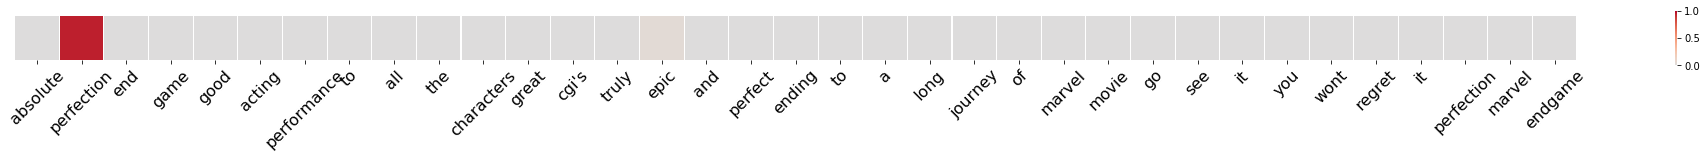

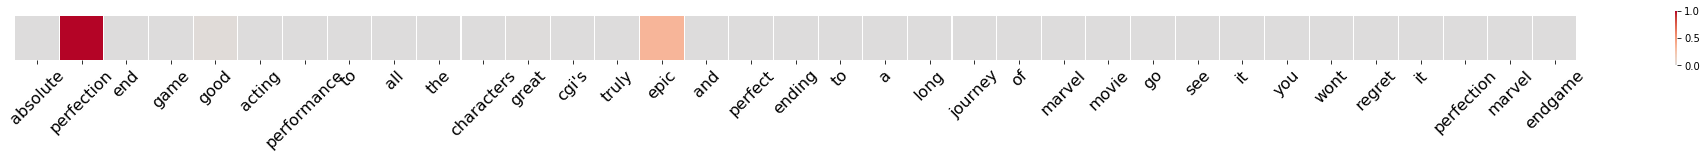

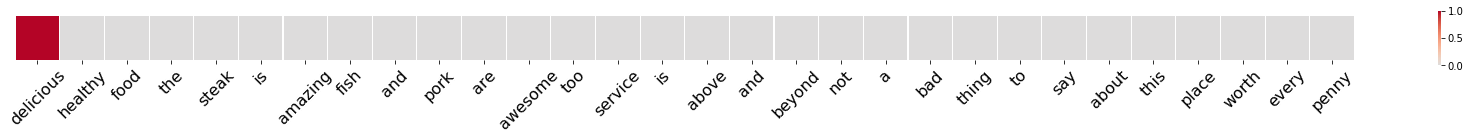

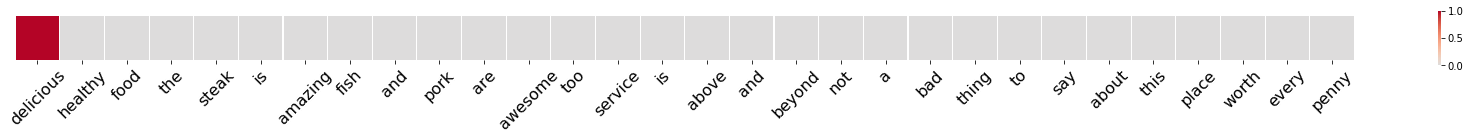

In [31]:
import matplotlib.pyplot as plt
import seaborn as sn

word_rev_index = {}
for word, i in tokenizer.word_index.items():
    word_rev_index[i] = word

def hierarchical_attention_analysis(review):        
    tokenized_sentences = doc2hierarchical(review)
    
    # word attention만 가져오기
    pred_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[0][0]
    for sent_idx, sentence in enumerate(tokenized_sentences):
        if sentence[-1] == 0:
            continue
            
        for word_idx in range(MAX_SENTENCE_LENGTH):
            if sentence[word_idx] != 0:
                words = [word_rev_index[word_id] for word_id in sentence[word_idx:]]
                pred_att = pred_attention[sent_idx][-len(words):]
                pred_att = np.expand_dims(pred_att, axis=0)
                break

        fig, ax = plt.subplots(figsize=(len(words), 1))
        plt.rc('xtick', labelsize=16)
        midpoint = (max(pred_att[:, 0]) - min(pred_att[:, 0])) / 2
        heatmap = sn.heatmap(pred_att, xticklabels=words, yticklabels=False, square=True, linewidths=0.1, cmap='coolwarm', center=midpoint, vmin=0, vmax=1)
        plt.xticks(rotation=45)
        plt.show()
        
def sequential_attention_analysis(review):        
    tokenized_sentence = doc2sequential(review)
    
    pred_attention = attention_extractor.predict(np.asarray([tokenized_sentence]))[0]
    
    for word_idx in range(MAX_SENTENCE_LENGTH):
        if tokenized_sentence[word_idx] != 0:
            words = [word_rev_index[word_id] for word_id in tokenized_sentence[word_idx:]]
            pred_att = pred_attention[-len(words):]
            pred_att = np.expand_dims(pred_att, axis=0)
            break

    fig, ax = plt.subplots(figsize=(len(words), 1))
    plt.rc('xtick', labelsize=16)
    midpoint = (max(pred_att[:, 0]) - min(pred_att[:, 0])) / 2
    heatmap = sn.heatmap(pred_att, xticklabels=words, yticklabels=False, square=True, linewidths=0.1, cmap='coolwarm', center=midpoint, vmin=0, vmax=1)
    plt.xticks(rotation=45)
    plt.show()
    
def sequential_normatt_analysis(review):        
    tokenized_sentence = doc2sequential(review)
    
    pred_representations = sequence_encoder.predict(np.asarray([tokenized_sentence]))[0]
    pred_attention = attention_extractor.predict(np.asarray([tokenized_sentence]))[0]
    weighted_representations = pred_representations * np.expand_dims(pred_attention, axis=-1)
    normatt = np.linalg.norm(weighted_representations, axis=-1)
    
    # print(pred_attention)
    
    for word_idx in range(MAX_SENTENCE_LENGTH):
        if tokenized_sentence[word_idx] != 0:
            words = [word_rev_index[word_id] for word_id in tokenized_sentence[word_idx:]]
            pred_att = normatt[-len(words):]
            pred_att = np.expand_dims(pred_att, axis=0)
            break

    fig, ax = plt.subplots(figsize=(len(words), 1))
    plt.rc('xtick', labelsize=16)
    midpoint = (max(pred_att[:, 0]) - min(pred_att[:, 0])) / 2
    heatmap = sn.heatmap(pred_att, xticklabels=words, yticklabels=False, square=True, linewidths=0.1, cmap='coolwarm', center=midpoint, vmax=1.0)
    plt.xticks(rotation=45)
    plt.show()
        
# hierarchical_attention_analysis("Absolute perfection end game !! Good acting performance to all the characters. Great cgi's. Truly epic & perfect ending to a long journey of marvel movie. Go see it you wont regret it !! Perfection Marvel Endgame !!")
# sequential_attention_analysis("Absolute perfection end game !! Good acting performance to all the characters. Great cgi's. Truly epic & perfect ending to a long journey of marvel movie. Go see it you wont regret it !! Perfection Marvel Endgame !!")

target_review = "Absolute perfection end game !! Good acting performance to all the characters. Great cgi's. Truly epic and perfect ending to a long journey of marvel movie. Go see it you wont regret it !! Perfection Marvel Endgame !!"
sequential_attention_analysis(target_review)
sequential_normatt_analysis(target_review)

# target_review = "Marvel 's The Avengers is quite possibly the greatest superhero movie in history. The combination of heroes mixes itself together into a concoction of personalities and superpowers which guarantees to impress."
target_review = "Delicious healthy food. The steak is amazing. Fish and pork are awesome too. Service is above and beyond. Not a bad thing to say about this place. Worth every penny!"
sequential_attention_analysis(target_review)
sequential_normatt_analysis(target_review)